# Customer Segmentation & Basket Mix Analysis

#### This notebook analyzes the Online Retail dataset, which contains transactional data for a UK based e-commerce store from 2010 to 2011. The objective is to perform a customer segmentation using RFM analysis to understand customer purchasing behavior, and to conduct a market basket analysis to uncover associations between products frequently bought together. These insights aim to support data driven business strategies for personalized marketing and product bundling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

## Data Wrangling

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.shape

(541909, 8)

#### After inspecting the data in excel the negative values in the Quantity and Unit Price columns stood out. They had visibly different product descriptions similar to that of credit transactions such as returns, discounts, or carrier charges, so we'll remove these rows from the dataset

In [7]:
df_purchase = df[(df.Quantity > 0) & (df.UnitPrice > 0)].copy()
df_purchase

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


#### Now we'll deal with any null values

In [8]:
print(df_purchase.isnull().sum(), '\n')
print(df_purchase.shape,'\n')

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64 

(530104, 8) 



#### We have 132,220 empty CustomerID fields, we could fill these in with "Unknown" but then it will skew our data of customers creating one huge customer that will certainly be an outstanding outlier, so instead we'll remove these rows from the database

In [9]:
df_purchase = df_purchase[df_purchase.CustomerID.notna()]
df_purchase.CustomerID = df_purchase.CustomerID.astype(int)
print(df_purchase.isnull().sum(), '\n')
print(df_purchase.shape,'\n')

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64 

(397884, 8) 



#### The Description column has a few formatting and spacing inconsistencies 

In [10]:
df_purchase['Description'] = df_purchase['Description'].str.replace('.','').str.upper().str.strip()
df_purchase['Description'] = df_purchase['Description'].replace('\s+',' ',regex = True)
df_purchase.Description = df_purchase.Description.str.replace(r"'S\b", "", regex=True)

df_purchase.Description.unique().tolist()[:50]

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'POPPY PLAYHOUSE BEDROOM',
 'POPPY PLAYHOUSE KITCHEN',
 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 'IVORY KNITTED MUG COSY',
 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 'BOX OF VINTAGE JIGSAW BLOCKS',
 'BOX OF VINTAGE ALPHABET BLOCKS',
 'HOME BUILDING BLOCK WORD',
 'LOVE BUILDING BLOCK WORD',
 'RECIPE BOX WITH METAL HEART',
 'DOORMAT NEW ENGLAND',
 'JAM MAKING SET WITH JARS',
 'RED COAT RACK PARIS FASHION',
 'YELLOW COAT RACK PARIS FASHION',
 'BLUE COAT RACK PARIS FASHION',
 'BATH BUILDING BLOCK WORD',
 'ALARM CLOCK BAKELIKE PINK',
 'ALARM CLOCK BAKELIKE RED',
 'ALARM CLOCK BAKELIKE GREEN',
 'PANDA AND BUNNIES STICKER SHEET',
 'STARS GIFT TAPE',
 'INFLATABLE POLITIC

#### After more data exploration we see theres some rows that are not product descriptors but are irrelevant debit transactions such as "Postage" or "Manual", so we'll remove these as well

In [11]:
non_products = ['POSTAGE', 'DOTCOM POSTAGE', 'CARRIAGE', 'NEXT DAY CARRIAGE', 'MANUAL']
df_purchase = df_purchase[~df_purchase.Description.str.upper().isin(non_products)]
df_purchase.shape

(396273, 8)

#### Now we'll do some feature engineering creating a revenue column and other date time features that may be useful

In [12]:
df_purchase['Revenue'] = df_purchase.UnitPrice * df_purchase.Quantity
df_purchase['Year'] = df_purchase.InvoiceDate.dt.year
df_purchase['Month'] = df_purchase.InvoiceDate.dt.month
df_purchase['Day'] = df_purchase.InvoiceDate.dt.day
df_purchase['Hour'] = df_purchase.InvoiceDate.dt.hour
df_purchase['Minute'] = df_purchase.InvoiceDate.dt.minute
df_purchase['DayOfWeek'] = df_purchase.InvoiceDate.dt.dayofweek
df_purchase['IsWeekend'] = df_purchase.DayOfWeek >= 5
df_purchase.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,8,26,2,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,8,26,2,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False


In [13]:
df_purchase.Year.unique()

array([2010, 2011], dtype=int32)

In [14]:
df_purchase[df_purchase.Year == 2010].Month.unique()

array([12], dtype=int32)

In [15]:
df_purchase[df_purchase.Year == 2011].Month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

#### We see that the data ranges from Dec 2010 to Dec 2011

In [16]:
df_purchase.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Revenue               float64
Year                    int32
Month                   int32
Day                     int32
Hour                    int32
Minute                  int32
DayOfWeek               int32
IsWeekend                bool
dtype: object

### Viewing for Outliers

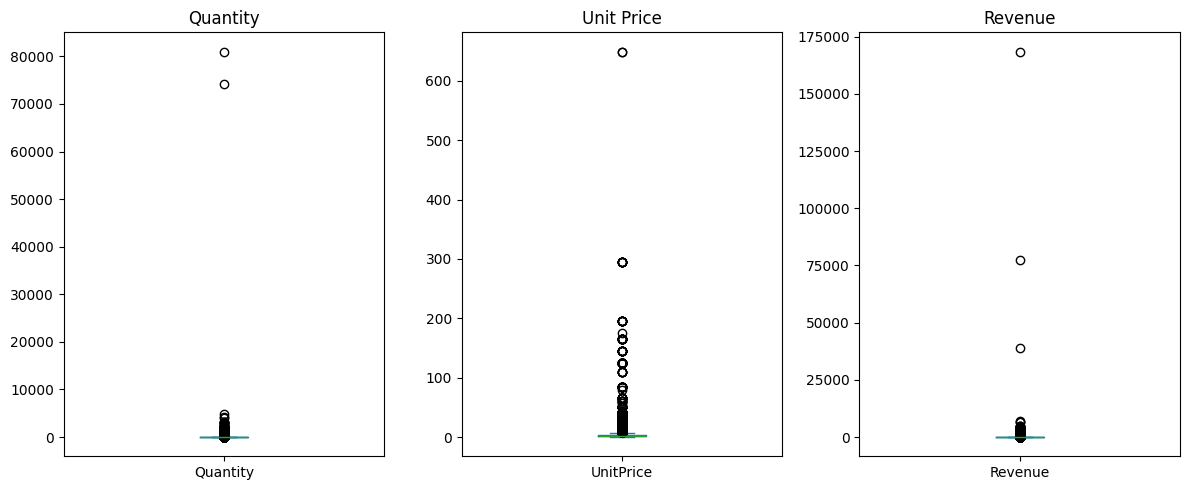

In [17]:
df_purchase[['Quantity', 'UnitPrice', 'Revenue']].plot.box(subplots=True, layout=(1, 3), figsize=(12, 5), title=['Quantity', 'Unit Price', 'Revenue'])
plt.tight_layout()
plt.show()

#### We can see some outliers in the dataset that show instances of higher quantity, unit price, and revenue. These customers are most likely businesses that are buying in bulk and spending alot more than the average customer

In [18]:
df_purchase.nlargest(2, 'Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False


In [19]:
df_purchase.nlargest(3, 'UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom,38970.0,2011,6,10,15,28,4,False
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom,649.5,2011,6,10,15,33,4,False
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145,United Kingdom,295.0,2010,12,2,18,6,3,False


In [20]:
df_purchase.nlargest(3, 'Revenue')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0,2011,6,10,15,28,4,False


#### I want to see the disparity of revenue across all customer ID's, as there is a difference between a regular customer and that of a business, which may be important to note

In [21]:
customer_monetary = df_purchase.groupby('CustomerID')['Revenue'].sum().reset_index()
customer_monetary.sort_values(by='Revenue', ascending=False).head(30)

,CustomerID,Revenue
1689,14646,279138.02
4198,18102,259657.30
3726,17450,194550.79
3007,16446,168472.50
1879,14911,136275.72
55,12415,124564.53
1333,14156,116729.63
3769,17511,91062.38
0,12346,77183.60
2701,16029,72882.09


#### We can see that we are dealing with a dataset that has both businesses and customers together. This distinction would probably be made by the RFM segmentation later on but for now I will create a column `IsBusiness` to identify if a customer ID is a business or a customer. This distinction will be made based on the total revenue the customers spent, if they spent more than 30,000 dollars they will be classified as a business

In [22]:
business_ids = customer_monetary[customer_monetary.Revenue > 30000]['CustomerID']
df_purchase['IsBusiness'] = df_purchase.CustomerID.isin(business_ids)

df_business = df_purchase[df_purchase.IsBusiness].copy()
df_consumers = df_purchase[~df_purchase.IsBusiness].copy()

print(df_business.CustomerID.nunique(), '\n')
print(df_consumers.CustomerID.nunique(), '\n')

31 

4304 



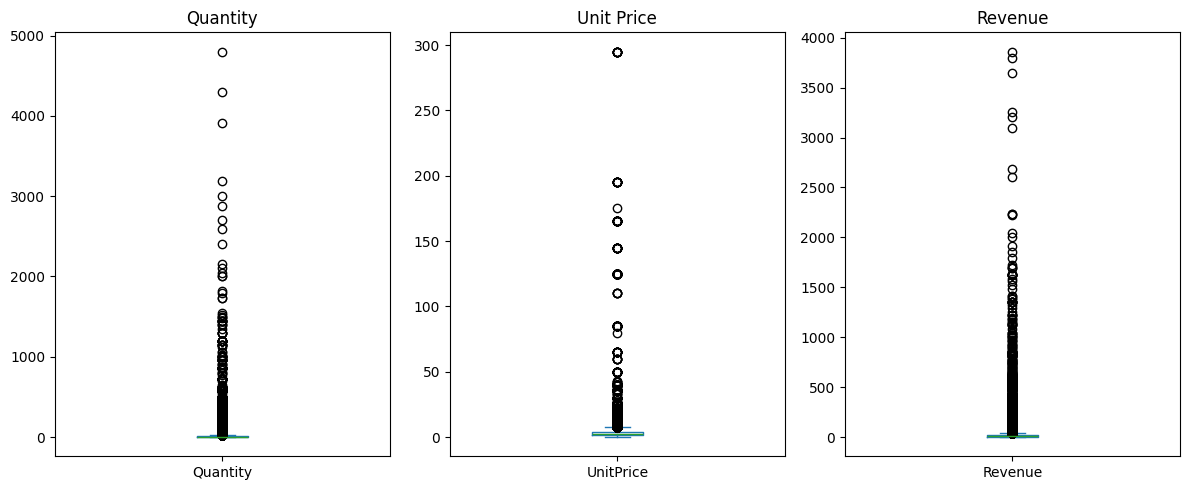

In [23]:
df_consumers[['Quantity', 'UnitPrice', 'Revenue']].plot.box(subplots=True, layout=(1, 3), figsize=(12, 5), title=['Quantity', 'Unit Price', 'Revenue'])
plt.tight_layout()
plt.show()

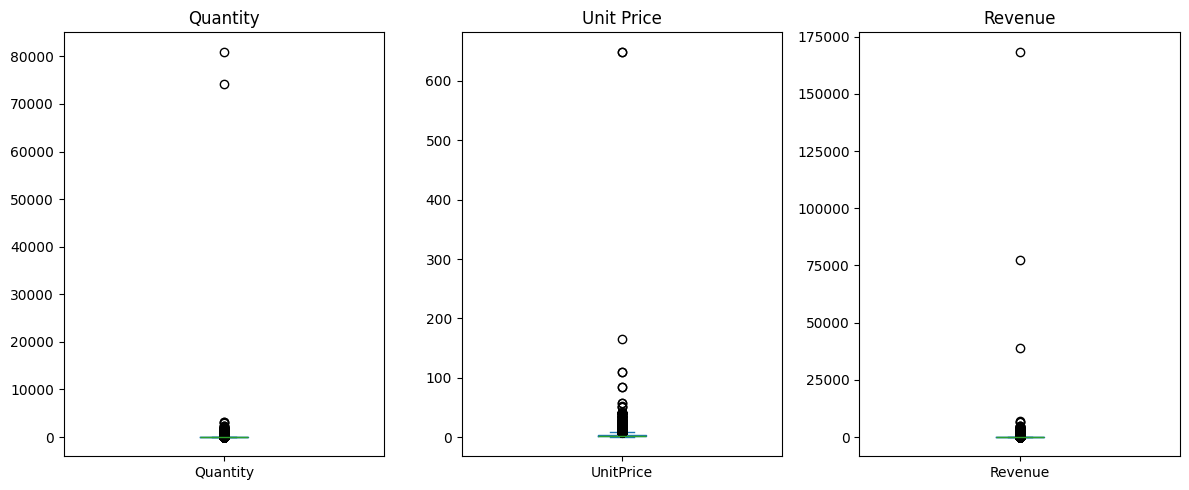

In [24]:
df_business[['Quantity', 'UnitPrice', 'Revenue']].plot.box(subplots=True, layout=(1, 3), figsize=(12, 5), title=['Quantity', 'Unit Price', 'Revenue'])
plt.tight_layout()
plt.show()

In [25]:
df_business.nlargest(2, 'Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend,IsBusiness
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False,True
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False,True


In [26]:
df_business.nlargest(2, 'Revenue')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend,IsBusiness
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9,9,15,4,False,True
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18,10,1,1,False,True


#### We can see the consumer dataframe now looks evenly distributed but the business customers still deal with outliers. After inspecting them there are two customers that jump out: `CustomerID` 16446 and 12346. These are probably big businesses that frequently purchase from this store causing the skew

#### Now we have three dataframes df_purchase (only debit transactions), df_consumers (segment of customers spending less than 30k a year), df_business (segment of customers that spend more than 30k a year). We'll now further explore this data in our EDA section

## EDA

#### I want to first dive into how each type of customer spends monthly

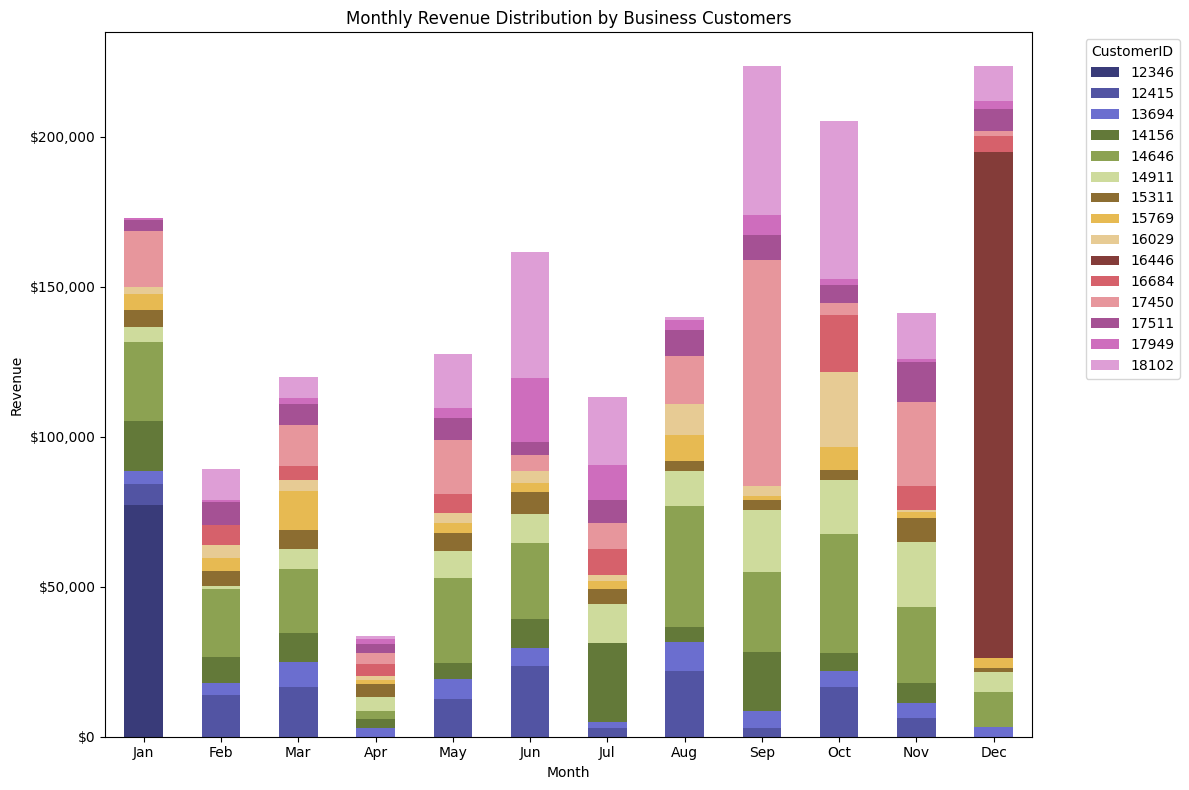

In [68]:
df_2011 = df_business[df_business.Year == 2011]
top15_customers = df_2011.groupby('CustomerID')['Revenue'].sum().nlargest(15).index
df_top15 = df_2011[df_2011.CustomerID.isin(top15_customers)]

monthly_rev = df_top15.groupby(['Month', 'CustomerID'])['Revenue'].sum().unstack(fill_value=0)
ax = monthly_rev.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20b',
                      title='Monthly Revenue Distribution by Business Customers')

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.legend(title='CustomerID', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.tight_layout()
plt.show()

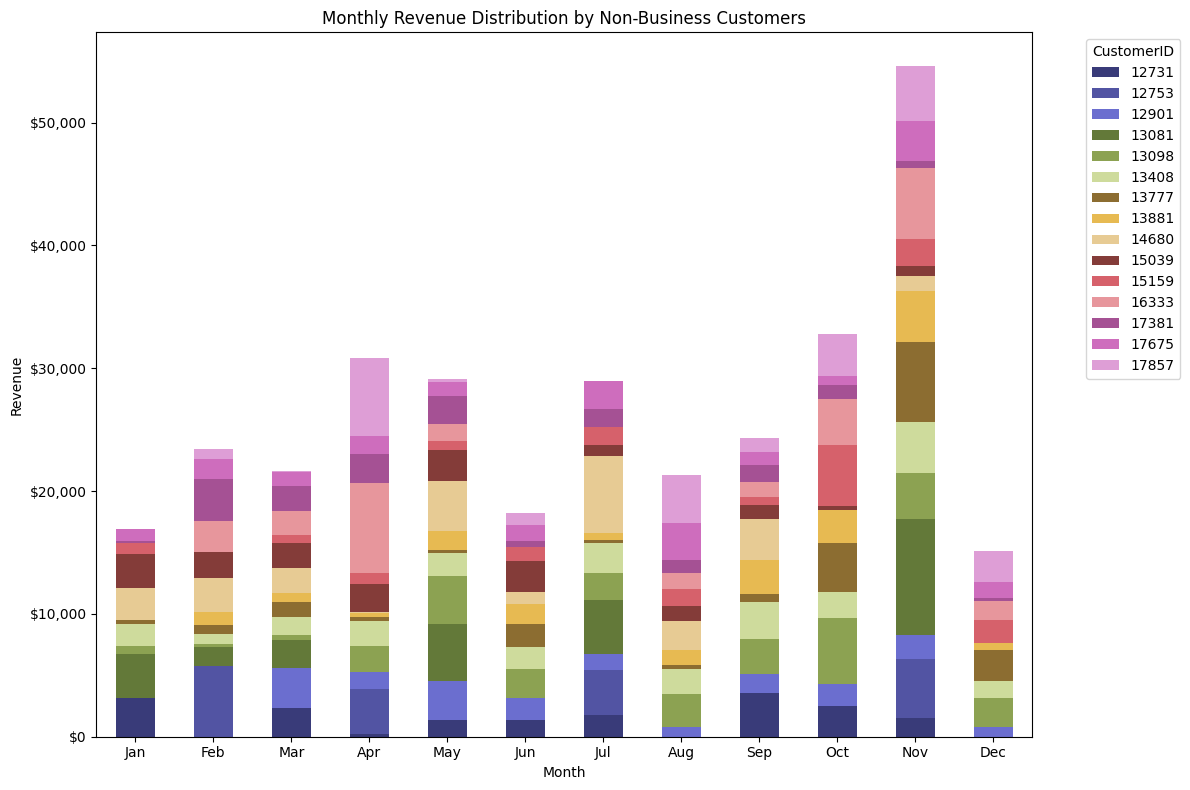

In [69]:
df_2011 = df_consumers[df_consumers.Year == 2011]
top15_customers = df_2011.groupby('CustomerID')['Revenue'].sum().nlargest(15).index
df_top15 = df_2011[df_2011.CustomerID.isin(top15_customers)]

monthly_rev = df_top15.groupby(['Month', 'CustomerID'])['Revenue'].sum().unstack(fill_value=0)
ax = monthly_rev.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20b',
                      title='Monthly Revenue Distribution by Non-Business Customers')

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.legend(title='CustomerID', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.tight_layout()
plt.show()

#### The top business customer, ID 16446, shows an exceptional revenue spike in December, greatly surpassing all others. In contrast, non-business customer revenue is more evenly distributed, with no single customer showing dominance across multiple months. It's interesting to note that customer 16446 and 12346 make all their purchases in December and January, respectfully, this could be due to seasonal retail demand, such as stocking up for the holiday shopping season or fulfilling end-of-year bulk orders. This is further evidence that these customers are either retailers or distributors purchasing in large quantities once annually to meet peak consumer demand. There is also tax reasons to make large purchases at the end of the year to maximize deductible business expense and reduce their taxable expense, its a common strategy for lowering year end tax liabilities

#### Now lets look at the revenue distribution by country


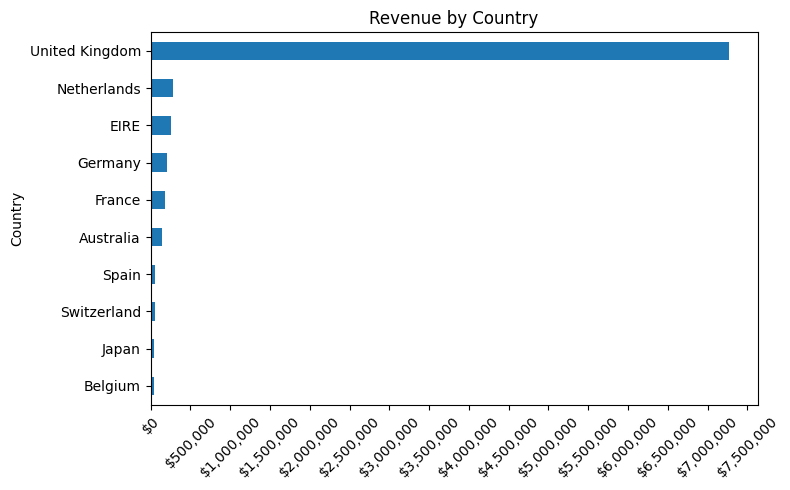

In [49]:
top10_rev = df_purchase.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

ax = top10_rev.plot(kind='barh', figsize=(8, 5), title='Revenue by Country')
plt.gca().invert_yaxis() 
ax.xaxis.set_major_locator(ticker.MultipleLocator(500000))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
df_purchase.CustomerID.nunique()

4335

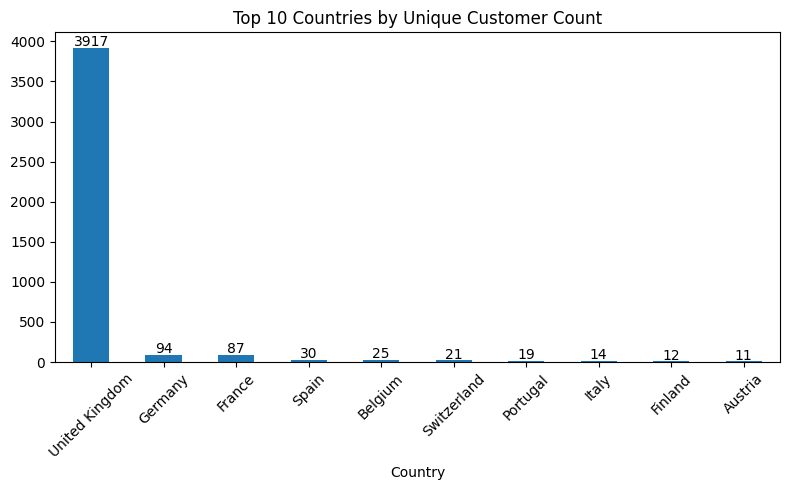

In [73]:
top_cust_countries = (df_purchase[df_purchase.CustomerID.notna()]
                      .groupby('Country')['CustomerID']
                      .nunique()
                      .sort_values(ascending=False)
                      .head(10))
ax = top_cust_countries.plot(kind='bar', figsize=(8, 5), title='Top 10 Countries by Unique Customer Count')
plt.xticks(rotation=45)

for i, value in enumerate(top_cust_countries):
    ax.text(i, value + 20, str(value), ha='center')

plt.tight_layout()
plt.show()

#### We see that the majority of our data is in the UK

#### Lets see how the monthly revenue compares between the UK and the rest of the countries

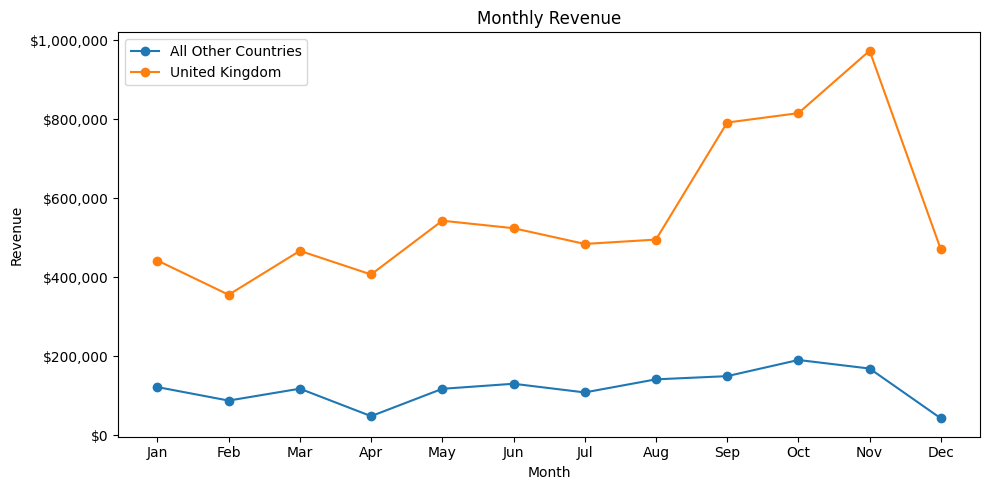

In [74]:
df_2011 = df_purchase[df_purchase.Year == 2011]
monthly_uk_vs_world = df_2011.groupby([
    df_2011.Country == 'United Kingdom',
    'Month'
])['Revenue'].sum().unstack(0)
monthly_uk_vs_world.columns = ['All Other Countries', 'United Kingdom']

ax = monthly_uk_vs_world.plot(figsize=(10, 5), marker='o', title='Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
plt.tight_layout()
plt.show()

#### We see that the UK generated significantly more revenue than the rest of the countries, with a sharp spike in October and November, likely due to seasonal holiday purchasing

#### Lets dive further into how purchases are spread throughout the week

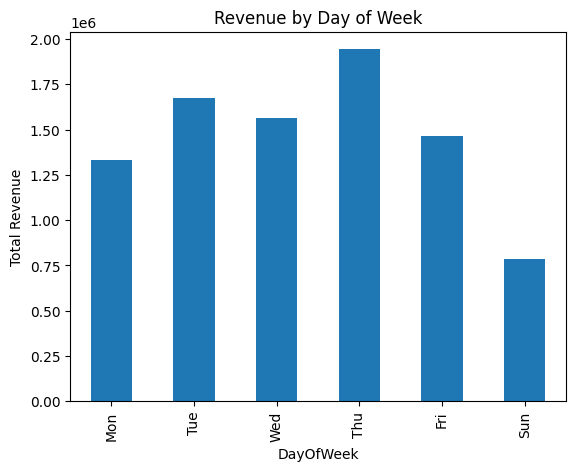

In [71]:
dow_map = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_purchase.groupby('DayOfWeek')['Revenue'].sum().rename(index=dict(enumerate(dow_map))).plot(kind='bar', title='Revenue by Day of Week')
plt.ylabel('Total Revenue')
plt.show()

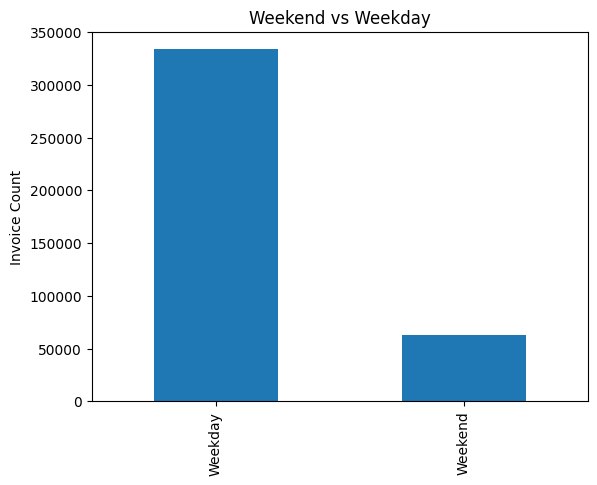

In [72]:
weekend_dist = df_purchase.groupby(['CustomerID', 'IsWeekend'])['InvoiceNo'].count().unstack(fill_value=0)
weekend_dist.columns = ['Weekday', 'Weekend']
weekend_dist.sum().plot(kind='bar', title='Weekend vs Weekday', ylabel='Invoice Count')
plt.show()

#### We see that most transactions happen on the weekday and that no transactions exist on Saturday, which seems to be odd for an online retailer, although its possible orders require manual processing/approval by staff

#### Lets dive deeper into the products itself

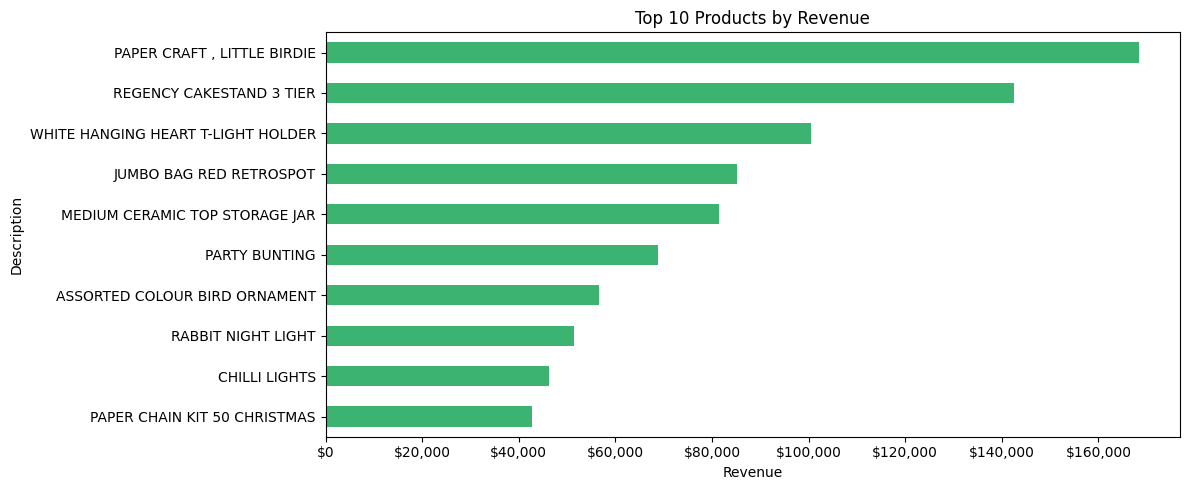

In [33]:
top10_products = df_purchase.groupby('Description')['Revenue'].sum().nlargest(10)
ax = top10_products.plot(kind='barh', figsize=(12, 5), title='Top 10 Products by Revenue', color='mediumseagreen')
plt.xlabel('Revenue')
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

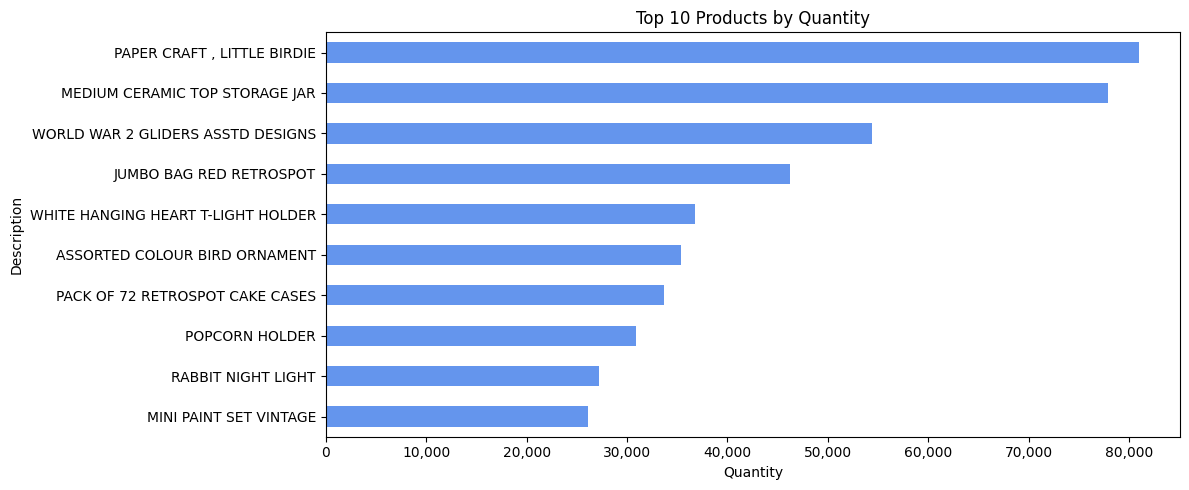

In [34]:
ax = df_purchase.groupby('Description')['Quantity'].sum().nlargest(10).plot(
    kind='barh', figsize=(12, 5), title='Top 10 Products by Quantity', color='cornflowerblue'
)
plt.xlabel('Quantity')
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

#### The product "PAPER CRAFT , LITTLE BIRDIE" dominates both revenue and quantity sold, indicating it is a high volume, high value item. However, other products like "REGENCY CAKESTAND 3 TIER" appear in the revenue chart but not in quantity, suggesting a high price point despite fewer units sold. Conversely, "WORLD WAR 2 GLIDERS ASSTD DESIGNS" shows up in the quantity chart but not revenue, implying it's a lower priced, high volume product

#### This concludes our EDA portion we'll now take the information we uncovered and attempt to understand the data even deeper by conducting a customer segmentation analysis

## Customer Segmentation

#### We'll perform a customer segmentation using RFM (Recency, Frequency, Monetary) analysis to categorize how recently (Recency) a customer made a purchase, how often (Frequency) they purchase, and how much they spend (Monetary). We'll also use clustering techniques to identify distinct customer groups and attempt to uncover actionable insights for targeted marketing and retention strategies

In [35]:
snapshot_date = df_purchase.InvoiceDate.max() + pd.Timedelta(days=1)
rfm = df_purchase.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1437.24
3,12349,19,1,1457.55
4,12350,310,1,294.40
...,...,...,...,...
4330,18280,278,1,180.60
4331,18281,181,1,80.82
4332,18282,8,2,178.05
4333,18283,4,16,2088.93


In [36]:
scaler = StandardScaler()
rfm_scaled = rfm.copy()
rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(
    rfm_scaled[['Recency', 'Frequency', 'Monetary']]
)
rfm_scaled.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2.328372,-0.425202,8.440059
1,12347,-0.905321,0.360385,0.257059
2,12348,-0.176742,-0.032408,-0.065525
3,12349,-0.735652,-0.425202,-0.063244
4,12350,2.168683,-0.425202,-0.193854


#### Determining the best value of K using the Elbow method and Silhouette scores

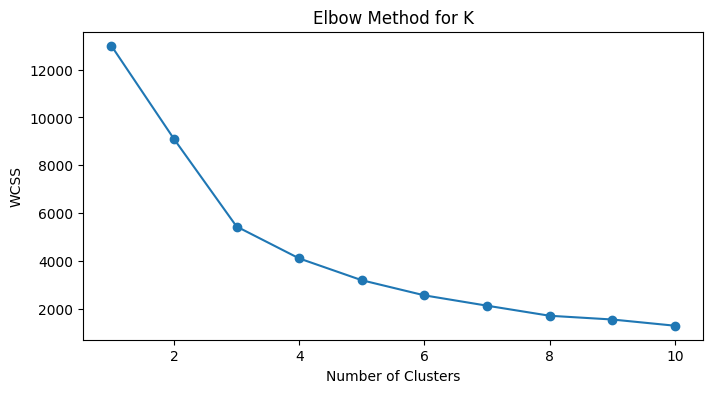

In [37]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for K')
plt.show()

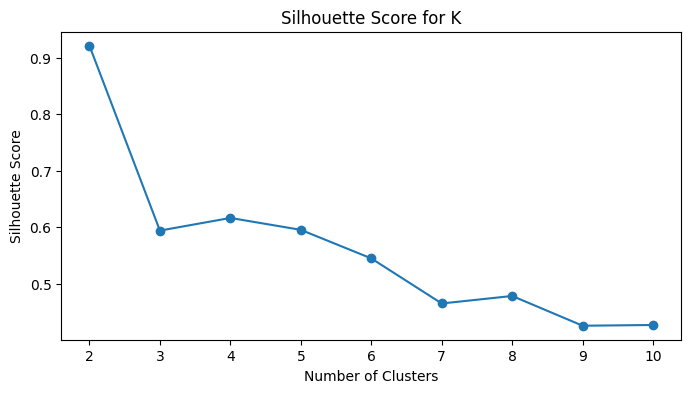

In [38]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    score = silhouette_score(rfm_scaled[['Recency', 'Frequency', 'Monetary']], labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K')
plt.show()

#### While the silhouette score peaks at 2 clusters, this likely reflects overfitting, capturing overly broad groupings with limited business insight. In contrast, the elbow method indicates that 3 clusters offers the best trade off between compactness and interpretability. Although 4 clusters show a slight improvement in silhouette score, the added complexity may not yield meaningful segmentation benefits for actionable business decisions

#### Lets now conduct K-Means clustering with 3 clusters, visualizing them in 3D and 2D

In [39]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_scaled['Segment'] = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

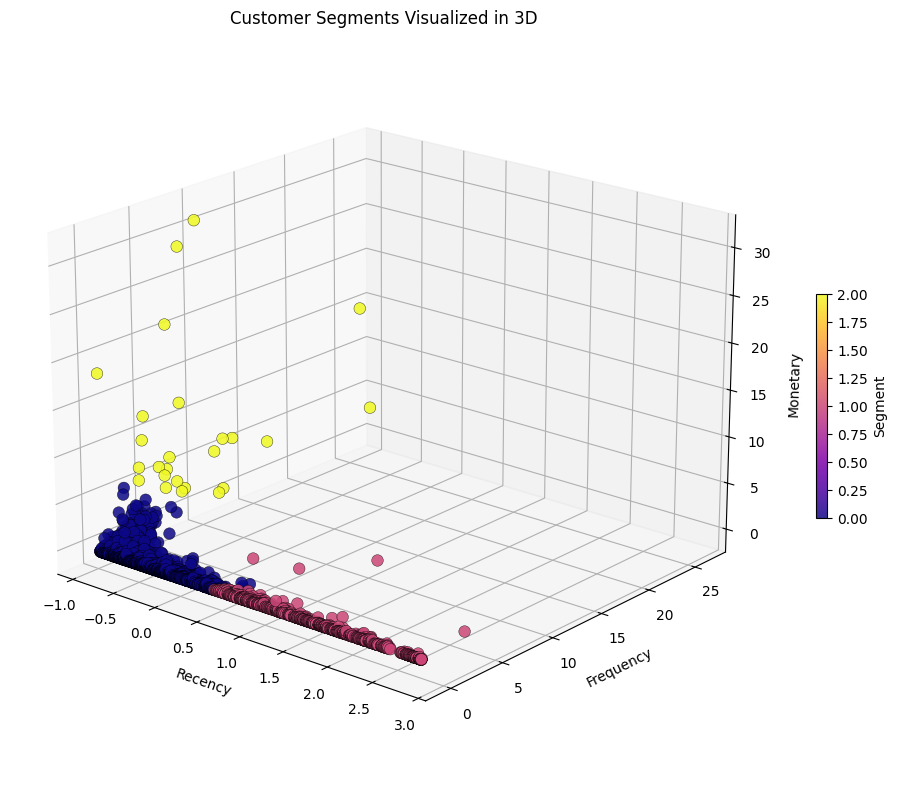

In [40]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm_scaled['Recency'],
    rfm_scaled['Frequency'],
    rfm_scaled['Monetary'],
    c=rfm_scaled['Segment'],
    cmap='plasma',
    s=70,
    alpha=0.85,
    edgecolors='black',  
    linewidth=0.3
)

ax.set_xlabel('Recency', labelpad=6)
ax.set_ylabel('Frequency', labelpad=6)
ax.set_zlabel('Monetary', labelpad=6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.view_init(elev=20, azim=2470)
ax.grid(True)
ax.set_title('Customer Segments Visualized in 3D')
plt.colorbar(scatter, ax=ax, shrink=0.3, label='Segment')
plt.tight_layout()
plt.show()

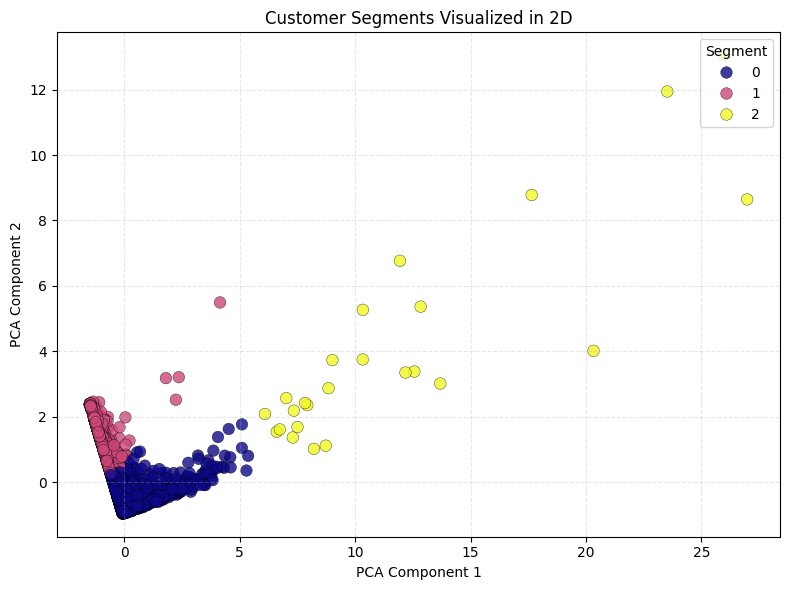

In [41]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
rfm_scaled['PCA1'] = pca_components[:, 0]
rfm_scaled['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_scaled,
    x='PCA1', y='PCA2',
    hue='Segment',
    palette='plasma', 
    alpha=0.8,
    s=70,
    edgecolor='black',
    linewidth=0.3
)
plt.grid(True, linestyle='--', alpha=0.3)
plt.title('Customer Segments Visualized in 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Segment', loc='upper right')
plt.tight_layout()
plt.show()

#### These 2D and 3D visualizations reveal clear distinctions between customer segments, with Segment 2 (yellow) representing high purchases, frequent buyers who are well separated from the rest. Segment 0 (dark blue) shows a dense cluster of lower frequency, lower monetary customers, while Segment 1 (pink) occupies a mid tier space

#### Lets look at what the unique characteristics are for each segment

In [42]:
rfm['Segment'] = rfm_scaled['Segment']

segment_profile = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).round(2)

print(segment_profile)

         Recency  Frequency  Monetary  NumCustomers
Segment                                            
0          41.42       4.65   1839.10          3226
1         247.34       1.57    625.97          1084
2           6.12      67.88  85941.88            25


#### Segment 0 (Mid-Value Customers): These customers purchase fairly frequently (avg 4.65 times), spend a moderate amount (avg $1,839), and have relatively recent activity
#### Segment 1 (Low-Value, Inactive Customers): This group has the highest recency (avg 247 days), indicating they haven’t purchased in a long time. Their frequency and monetary value are both low, suggesting low engagement and spend.
#### Segment 2 (High-Value, Loyal Customers): Although this segment contains only 25 customers, they purchase very frequently (avg 67.88 times) and spend significantly (avg $85,942), these would be the most loyal and profitable customers

#### Lets now explore the market basket analysis

## Market Basket Analysis

#### To better understand customer purchasing behavior, we apply association rules within each customer segment, helping identify frequently co-purchased items and uncovering product affinities that can inform cross-selling, bundling strategies, and merchandising decisions

In [43]:
df_purchase['Segment'] = df_purchase.CustomerID.map(rfm.set_index('CustomerID')['Segment'])
df_purchase

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Hour,Minute,DayOfWeek,IsWeekend,IsBusiness,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,8,26,2,False,False,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False,False,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,8,26,2,False,False,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False,False,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,8,26,2,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011,12,9,12,50,4,False,False,0
541905,581587,22899,CHILDREN APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011,12,9,12,50,4,False,False,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,12,9,12,50,4,False,False,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,12,9,12,50,4,False,False,0


In [44]:
rules_by_segment = {}

for seg in df_purchase['Segment'].dropna().unique():
    df_seg = df_purchase[df_purchase['Segment'] == seg]
    transactions = df_seg.groupby('InvoiceNo')['Description'].unique().tolist()
    te = TransactionEncoder()
    basket = te.fit(transactions).transform(transactions)
    basket_df = pd.DataFrame(basket, columns=te.columns_)

    # Adjusting threshold to include more unique items 
    seg_size = len(df_seg['CustomerID'].unique())
    min_support = 0.01 if seg_size < 100 else 0.02
    frequent_items = apriori(basket_df, min_support=min_support, use_colnames=True)

    # Stricter lift/confidence
    rules = association_rules(frequent_items, metric='lift', min_threshold=1.2)
    rules = rules[rules['confidence'] >= 0.5] 
    rules_by_segment[seg] = rules

In [45]:
for seg, rules in rules_by_segment.items():
    print(f"\nTop Rules for Segment {seg}:")
    display(rules.sort_values(by='lift', ascending=False).head(10))


Top Rules for Segment 1:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
39,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.032845,0.039883,0.024633,0.750000,18.805147,1.0,0.023324,3.840469,0.978977,0.512195,0.739615,0.683824
34,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.039883,0.032845,0.024633,0.617647,18.805147,1.0,0.023324,2.529483,0.986154,0.512195,0.604662,0.683824
35,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.026979,0.051613,0.024633,0.913043,17.690217,1.0,0.023241,10.906452,0.969632,0.456522,0.908311,0.695158
36,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.027566,0.052199,0.024633,0.893617,17.119292,1.0,0.023195,8.909326,0.968278,0.446809,0.887758,0.682764
45,(GREEN REGENCY TEACUP AND SAUCER),"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",0.051613,0.029912,0.026393,0.511364,17.095588,1.0,0.024849,1.985296,0.992744,0.478723,0.496297,0.696858
40,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",(GREEN REGENCY TEACUP AND SAUCER),0.029912,0.051613,0.026393,0.882353,17.095588,1.0,0.024849,8.061290,0.970536,0.478723,0.875950,0.696858
11,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.032845,0.051613,0.027566,0.839286,16.261161,1.0,0.025871,5.901075,0.970375,0.484536,0.830539,0.686688
10,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.051613,0.032845,0.027566,0.534091,16.261161,1.0,0.025871,2.075846,0.989579,0.484536,0.518269,0.686688
24,(ROSES REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.052199,0.032845,0.026979,0.516854,15.736356,1.0,0.025265,2.001787,0.988027,0.464646,0.500446,0.669141
25,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.032845,0.052199,0.026979,0.821429,15.736356,1.0,0.025265,5.307683,0.968255,0.464646,0.811594,0.669141



Top Rules for Segment 0:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
94,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.035441,0.022850,0.020252,0.571429,25.007913,1.0,0.019442,2.280017,0.995286,0.532399,0.561407,0.728863
91,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.022850,0.035441,0.020252,0.886297,25.007913,1.0,0.019442,8.483176,0.982462,0.532399,0.882120,0.728863
95,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.029645,0.027447,0.020252,0.683146,24.890062,1.0,0.019438,3.069406,0.989146,0.549729,0.674204,0.710505
90,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.027447,0.029645,0.020252,0.737864,24.890062,1.0,0.019438,3.701725,0.986911,0.549729,0.729856,0.710505
11,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029645,0.035441,0.024382,0.822472,23.207003,1.0,0.023331,5.433277,0.986144,0.599018,0.815949,0.755221
10,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.035441,0.029645,0.024382,0.687970,23.207003,1.0,0.023331,3.109813,0.992069,0.599018,0.678437,0.755221
92,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.024382,0.040770,0.020252,0.830601,20.372799,1.0,0.019258,5.662551,0.974680,0.451039,0.823401,0.663667
13,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.035441,0.040770,0.027447,0.774436,18.995196,1.0,0.026002,4.252586,0.982164,0.562842,0.764849,0.723819
12,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.040770,0.035441,0.027447,0.673203,18.995196,1.0,0.026002,2.951552,0.987620,0.562842,0.661195,0.723819
83,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.029645,0.040770,0.022850,0.770787,18.905680,1.0,0.021641,4.184876,0.976040,0.480392,0.761044,0.665622



Top Rules for Segment 2:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
371,(HERB MARKER ROSEMARY),(HERB MARKER PARSLEY),0.010607,0.010018,0.010018,0.944444,94.277778,1.0,0.009911,17.819682,1.000000,0.944444,0.943882,0.972222
370,(HERB MARKER PARSLEY),(HERB MARKER ROSEMARY),0.010018,0.010607,0.010018,1.000000,94.277778,1.0,0.009911,inf,0.999405,0.944444,1.000000,0.972222
368,(HERB MARKER BASIL),(HERB MARKER ROSEMARY),0.010607,0.010607,0.010018,0.944444,89.040123,1.0,0.009905,17.809075,0.999369,0.894737,0.943849,0.944444
369,(HERB MARKER ROSEMARY),(HERB MARKER BASIL),0.010607,0.010607,0.010018,0.944444,89.040123,1.0,0.009905,17.809075,0.999369,0.894737,0.943849,0.944444
2460,"(ROSES REGENCY TEACUP AND SAUCER, REGENCY TEA ...","(REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP ...",0.012375,0.011786,0.010018,0.809524,68.688095,1.0,0.009872,5.188126,0.997789,0.708333,0.807252,0.829762
2473,"(REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP ...","(ROSES REGENCY TEACUP AND SAUCER, REGENCY TEA ...",0.011786,0.012375,0.010018,0.850000,68.688095,1.0,0.009872,6.584168,0.997194,0.708333,0.848121,0.829762
2251,"(REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP ...","(ROSES REGENCY TEACUP AND SAUCER, REGENCY TEA ...",0.011786,0.012964,0.010018,0.850000,65.565909,1.0,0.009865,6.580240,0.996492,0.680000,0.848030,0.811364
2467,"(REGENCY TEA PLATE ROSES, PINK REGENCY TEACUP ...","(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.012964,0.011786,0.010018,0.772727,65.565909,1.0,0.009865,4.348144,0.997682,0.680000,0.770017,0.811364
2466,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...","(REGENCY TEA PLATE ROSES, PINK REGENCY TEACUP ...",0.011786,0.012964,0.010018,0.850000,65.565909,1.0,0.009865,6.580240,0.996492,0.680000,0.848030,0.811364
2246,"(ROSES REGENCY TEACUP AND SAUCER, REGENCY TEA ...","(REGENCY TEA PLATE GREEN, PINK REGENCY TEACUP ...",0.012964,0.011786,0.010018,0.772727,65.565909,1.0,0.009865,4.348144,0.997682,0.680000,0.770017,0.811364


#### The association rule analysis reveals that Segment 0 and Segment 1 share many overlapping rules involving various "REGENCY TEACUP AND SAUCER" items, suggesting these products are consistently bought together by moderate value and high value customers alike. However, Segment 2 stands out with specific and niche product combinations (like herb markers and themed tea sets), indicating this small group of high frequency, high spending customers engages in more curated or themed purchases, which offers targeting opportunities

## Conclusion

#### This analysis provided valuable insights into customer behavior and purchasing patterns through RFM based segmentation and Market Basket analysis. The customer segmentation revealed distinct groups with varying levels of engagement and value, enabling more targeted marketing strategies. Additionally, the basket mix analysis uncovered frequent product pairings within segments, offering actionable recommendations for personalized promotions and optimized product placements. Together, these approaches equip the business with data driven strategies to enhance customer retention and maximize revenue opportunities